In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets scikit-learn pandas sentencepiece


In [ ]:
!pip install openpyxl


In [ ]:
# ============================
# Cell 3 — Dataset Loading +  (UPDATED)
# ============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

# Path to your Excel file (Kaggle)
DATA_PATH = "/content/drive/MyDrive/final_prepared_amharic_news_dataset.xlsx"

# Real column names
TEXT_COLUMN = "text"
LABEL_ID_COLUMN = "label_id"
LABEL_NAME_COLUMN = "label"

# -----------------------------
# Load the dataset
# -----------------------------
df = pd.read_excel(DATA_PATH)

print("Raw columns:", df.columns.tolist())

# Validate required columns
required = {TEXT_COLUMN, LABEL_ID_COLUMN, LABEL_NAME_COLUMN}
missing = required - set(df.columns)

if missing:
    raise ValueError(f"❌ Missing required columns: {missing}")

# Keep only relevant columns
df = df[[TEXT_COLUMN, LABEL_ID_COLUMN, LABEL_NAME_COLUMN]].copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Ensure label format
df[LABEL_ID_COLUMN] = df[LABEL_ID_COLUMN].astype(int)

print("Dataset shape after cleaning:", df.shape)

Raw columns: ['text', 'label', 'label_id', 'input_text', 'target_text']
Dataset shape after cleaning: (2609, 3)


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED = "Davlan/bert-base-multilingual-cased-finetuned-amharic"

# -------------------------------------
# SAFE LIMITS FOR COLAB
# -------------------------------------
MODEL_MAX_LEN = 512

CHUNK_SIZE = 256      # Not 512 (too large for Colab)
MAX_CHUNKS = 6        # Not 8
TOP_K_KEYS = 4        # Must be <= MAX_CHUNKS

# ChuLo hyperparameters
CHUNK_DMODEL = 256    # Reduce transformer hidden dim
KEY_ALPHA = 1.0
CHUNK_TRANSFORMER_LAYERS = 2  # reduce depth
DROPOUT = 0.1

# Training settings
BATCH_SIZE = 2        # Crucial
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
ADAM_EPS = 1e-8
WARMUP_RATIO = 0.1

MODEL_SAVE_DIR = "./chulo_mbert_checkpoint"
SEED = 42


In [ ]:
# ================================
# Cell 5 — Amharic Preprocessing
# ================================

import re

def preprocess_amharic(text):
    if text is None:
        return ""
    text = str(text)

    # STEP 1 — Remove ALL Unicode whitespace and invisible chars
    text = re.sub(
        r"[\u00A0\u202F\u205F\u1680\u180E"
        r"\u2000-\u200A"
        r"\u200B-\u200D"
        r"\u202A-\u202E"
        r"\u2060-\u2064"
        r"\uFEFF"
        r"\u00AD"
        r"\t\r\n]+",
        " ",
        text
    )

    # STEP 2 — Amharic normalization
    replacements = [
        ('[ሃሕላሐሓኻ]', 'ሀ'),
        ('[ሑኁዅ]', 'ሁ'),
        ('[ሒሂዺ]', 'ሂ'),
        ('[ሔሄዌ]', 'ሄ'),
        ('[ህሕ]', 'ህ'),
        ('[ሖሆዾ]', 'ሆ'),
        ('[ሠ]', 'ሰ'),
        ('[ሡ]', 'ሱ'),
        ('[ሢ]', 'ሲ'),
        ('[ሣ]', 'ሳ'),
        ('[ሤ]', 'ሴ'),
        ('[ሥ]', 'ስ'),
        ('[ሦ]', 'ሶ'),
        ('[ዓሣዐኣ]', 'አ'),
        ('[ዑ]', 'ኡ'),
        ('[ዒ]', 'ኢ'),
        ('[ዔ]', 'ኤ'),
        ('[ዕ]', 'እ'),
        ('[ዖ]', 'ኦ'),
        ('[ጸ]', 'ፀ'),
        ('[ጹ]', 'ፁ'),
        ('[ጺ]', 'ፂ'),
        ('[ጻ]', 'ፃ'),
        ('[ጼ]', 'ፄ'),
        ('[ጽ]', 'ፅ'),
        ('[ጾ]', 'ፆ'),
        ('(ሉ[ዋአ])','ሏ'),
        ('(ሙ[ዋአ])','ሟ'),
        ('(ቱ[ዋአ])','ቷ'),
        ('(ሩ[ዋአ])','ሯ'),
        ('(ሱ[ዋአ])','ሷ'),
        ('(ሹ[ዋአ])','ሿ'),
        ('(ቁ[ዋአ])','ቋ'),
        ('(ቡ[ዋአ])','ቧ'),
        ('(ቹ[ዋአ])','ቿ'),
        ('(ሁ[ዋአ])','ኋ'),
        ('(ኑ[ዋአ])','ኗ'),
        ('(ኙ[ዋአ])','ኟ'),
        ('(ኩ[ዋአ])','ኳ'),
        ('(ዙ[ዋአ])','ዟ'),
        ('(ጉ[ዋአ])','ጓ'),
        ('(ደ[ዋአ])','ዷ'),
        ('(ጡ[ዋአ])','ጧ'),
        ('(ጩ[ዋአ])','ጯ'),
        ('(ጹ[ዋአ])','ጿ'),
        ('(ፉ[ዋአ])','ፏ'),
        ('[ቊ]', 'ቁ'),
        ('[ኵ]', 'ኩ')
    ]
    for p, r in replacements:
        text = re.sub(p, r, text)

    # STEP 3 — remove non-Ethiopic letters
    text = re.sub(r"[A-Za-z0-9!\"#$%&'()*+,\-./:;<=>?@\[\\\]^_`{|}~]", "", text)
    text = re.sub(r"[፡።፣፤፥፦፧]", " ", text)

    # STEP 4 — Keep only Ethiopic range + space
    text = re.sub(r"[^\u1200-\u137F ]", " ", text)

    # STEP 5 — Normalize multiple spaces
    text = re.sub(r"\s+", " ", text)

    # STEP 6 — Remove leading/trailing invisible spaces
    text = re.sub(
        r"^[\s\u00A0\u202F\u205F\u1680\u180E\u200B-\u200D\u2060-\u2064\uFEFF]+"
        r"|[\s\u00A0\u202F\u205F\u1680\u180E\u200B-\u200D\u2060-\u2064\uFEFF]+$",
        "",
        text
    )

    return text

# ------------------------------------------
# Apply preprocessing and overwrite TEXT_COLUMN
# ------------------------------------------
df[TEXT_COLUMN] = df["text"].apply(preprocess_amharic)

print(df.head())


                                                text  label_id       label
0  በመገንባት ሀይ ያሉት የኢንዲስትሪ ፓርኮች በተያዘሀቸው ጊዜ ተጠናቀው ወደ...         2     economy
1  መስከረም ዋልታ ጠቅሀይ ሚኒስትር አቢይ አሀመድ ዶር በሳይንስ ሙዚየም በመ...         7  technology
2  በታሀቁ ህዳሴ ግድብ የጎዳና ሀይ ሩጫ ከ ሺህ በሀይ ሰዎች ይሳተፋሉአዲስ ...         6       sport
3  ስፖርት ሰሀም ፍቅር የአብ ሮነትና የአንድነት የመተሳ ሰብ የወንድማማችነት...         6       sport
4  ለዚህም ሚሊየን ዶሀር ወጪ የተደረገበት የደረጃ የጨቅሀ ህፃናት ፅኑ ህክም...         4      health


In [ ]:
# ================================
# Cell 6 — Dataset Split + ChuLo Chunk Encoding (IMPROVED)
# ================================

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from transformers import AutoTokenizer

# -------------------------------
# Tokenizer and constants
# -------------------------------
#PRETRAINED = "Davlan/bert-base-multilingual-cased-finetuned-amharic"
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED, use_fast=True)
MODEL_MAX_LEN = tokenizer.model_max_length

CHUNK_SIZE = 512      # chunk length including CLS + SEP
MAX_CHUNKS = 8        # max number of chunks per document
CHUNK_OVERLAP = 20    # optional overlap between chunks

TEXT_COLUMN = "text"
LABEL_ID_COLUMN = "label_id"
LABEL_NAME_COLUMN = "label"

# -------------------------------
# Load and preprocess dataset
# -------------------------------
df = pd.read_excel(DATA_PATH)
df = df[[TEXT_COLUMN, LABEL_ID_COLUMN, LABEL_NAME_COLUMN]].dropna().reset_index(drop=True)
df[LABEL_ID_COLUMN] = df[LABEL_ID_COLUMN].astype(int)
df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(preprocess_amharic)

# -------------------------------
# Train/val/test split
# -------------------------------
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df[LABEL_ID_COLUMN], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df[LABEL_ID_COLUMN], random_state=42
)

print("Train/Val/Test sizes:", train_df.shape, val_df.shape, test_df.shape)

# -------------------------------
# Label maps
# -------------------------------
label_map_df = df[[LABEL_ID_COLUMN, LABEL_NAME_COLUMN]].drop_duplicates().sort_values(LABEL_ID_COLUMN)
id2label = {int(r[LABEL_ID_COLUMN]): str(r[LABEL_NAME_COLUMN]) for _, r in label_map_df.iterrows()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
print("num_labels:", num_labels)

# -------------------------------
# ChuLo chunk encoder
# -------------------------------
def encode_chunks(text, chunk_size=CHUNK_SIZE, max_chunks=MAX_CHUNKS, overlap=CHUNK_OVERLAP):
    token_ids = tokenizer.encode(text, add_special_tokens=False, truncation=True)
    per_chunk_payload = chunk_size - 2
    max_total = per_chunk_payload * max_chunks

    if len(token_ids) > max_total:
        token_ids = token_ids[:max_total]

    # Split into chunks with optional overlap
    chunks = []
    i = 0
    while i < len(token_ids) and len(chunks) < max_chunks:
        chunk = token_ids[i:i+per_chunk_payload]
        chunks.append(chunk)
        i += per_chunk_payload - overlap  # move with overlap

    # Pad empty chunks
    while len(chunks) < max_chunks:
        chunks.append([])

    # Add CLS/SEP and pad to chunk_size
    processed = []
    for ch in chunks[:max_chunks]:
        ch = [tokenizer.cls_token_id] + ch + [tokenizer.sep_token_id]
        if len(ch) < chunk_size:
            ch += [tokenizer.pad_token_id] * (chunk_size - len(ch))
        else:
            ch = ch[:chunk_size]
        processed.append(ch)

    return torch.tensor(processed, dtype=torch.long)

# -------------------------------
# Convert DataFrame → ChuLo-ready tensors
# -------------------------------
def convert_dataframe(df):
    input_ids = []
    labels = []

    for _, row in df.iterrows():
        text = row[TEXT_COLUMN]
        label = int(row[LABEL_ID_COLUMN])
        chunk_tensor = encode_chunks(text)
        input_ids.append(chunk_tensor)
        labels.append(label)

    # Stack into tensor [num_samples, MAX_CHUNKS, CHUNK_SIZE]
    input_ids = torch.stack(input_ids)
    labels = torch.tensor(labels, dtype=torch.long)

    return {"input_ids": input_ids, "labels": labels}

# -------------------------------
# Convert datasets
# -------------------------------
print("Converting train set...")
train_data = convert_dataframe(train_df)
print("Converting validation set...")
val_data = convert_dataframe(val_df)
print("Converting test set...")
test_data = convert_dataframe(test_df)

print("✅ ChuLo-ready datasets created with chunk overlap!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/798 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Train/Val/Test sizes: (1826, 3) (391, 3) (392, 3)
num_labels: 8
Converting train set...
Converting validation set...
Converting test set...
✅ ChuLo-ready datasets created with chunk overlap!


In [ ]:
# ================================
# Cell 7 — ChuLo Model Definition (FINAL + SAFE)
# ================================

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from typing import List

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED, use_fast=True)

# Model max length (mBERT = 512)
MODEL_MAX_LEN = getattr(tokenizer, "model_max_length", 512)

# Auto-correct CHUNK_SIZE if needed
if CHUNK_SIZE > MODEL_MAX_LEN:
    print(f"⚠️ CHUNK_SIZE={CHUNK_SIZE} > model_max_length={MODEL_MAX_LEN}. Reducing...")
    CHUNK_SIZE = MODEL_MAX_LEN - 2   # allow CLS/SEP


# -------------------------------------------------------
# ChuLoMBERT (FIXED + SAFE VERSION)
# -------------------------------------------------------
class ChuLoMBERT(nn.Module):
    def __init__(self,
                 pretrained_name,
                 num_labels,
                 chunk_size=CHUNK_SIZE,
                 max_chunks=MAX_CHUNKS,
                 top_k_keys=TOP_K_KEYS,
                 d_model=CHUNK_DMODEL,
                 dropout=DROPOUT):

        super().__init__()

        # 1. Load BERT encoder
        self.bert = AutoModel.from_pretrained(pretrained_name)
        self.hidden_size = self.bert.config.hidden_size  # usually 768

        self.chunk_size = chunk_size
        self.max_chunks = max_chunks
        self.top_k_keys = top_k_keys
        self.d_model = d_model

        # 2. Project BERT hidden → d_model (IMPORTANT FIX)
        self.proj = nn.Linear(self.hidden_size, d_model)

        # 3. Keyphrase scorer (on d_model)
        self.key_scorer = nn.Linear(d_model, 1)

        # 4. Chunk-level Transformer (Multi-Head Attention)
        self.attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )

        # 5. Final classifier
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)


    def forward(self, input_ids, attention_mask=None, labels=None):
        """
        input_ids: (B, C, T)
        attention_mask: (B, C, T)
        """
        B, C, T = input_ids.size()

        # ----------------------------------------------------
        # HARD SAFETY: Never allow >512 tokens per chunk
        # ----------------------------------------------------
        if T > 512:
            input_ids = input_ids[:, :, :512]
            if attention_mask is not None:
                attention_mask = attention_mask[:, :, :512]
            T = 512

        # Flatten (B*C, T) for BERT
        flat_ids = input_ids.reshape(B * C, T)

        if attention_mask is None:
            flat_mask = (flat_ids != tokenizer.pad_token_id).long()
        else:
            flat_mask = attention_mask.reshape(B * C, T)

        # --- Step 1: Encode with BERT ---
        bert_out = self.bert(
            input_ids=flat_ids,
            attention_mask=flat_mask
        )

        # Take CLS token
        cls_vec = bert_out.last_hidden_state[:, 0, :]  # (BC, H)

        # Project BERT hidden → d_model
        chunk_vecs = self.proj(cls_vec)                 # (BC, d_model)

        # Reshape back to (B, C, d_model)
        chunk_vecs = chunk_vecs.view(B, C, self.d_model)

        # --- Step 2: Score chunks for importance ---
        scores = self.key_scorer(chunk_vecs).squeeze(-1)  # (B, C)

        # Select top-k chunks
        k = min(self.top_k_keys, C)
        top_idx = torch.topk(scores, k=k, dim=1).indices  # (B, k)

        batch_idx = torch.arange(B).unsqueeze(1).to(input_ids.device)
        selected = chunk_vecs[batch_idx, top_idx]          # (B, k, d_model)

        # --- Step 3: Chunk-level transformer ---
        att_output, _ = self.attention(
            selected,
            selected,
            selected
        )

        # Aggregate to document vector
        doc_vec = att_output.mean(dim=1)  # (B, d_model)

        # --- Step 4: Output layer ---
        logits = self.classifier(self.dropout(doc_vec))

        if labels is not None:
            labels = labels.to(input_ids.device)
            loss = nn.CrossEntropyLoss()(logits, labels)
            return loss, logits

        return logits


In [ ]:
# ================================
# Cell 8 — ChuLo Dataset (KEYPHRASE-BASED)
# ================================

import torch
from torch.utils.data import Dataset
import numpy as np

# -------------------------------------------------------------
# 1️⃣ Convert document → ChuLo keyphrase chunks
# -------------------------------------------------------------
def encode_document_chulo(text, tokenizer, chunk_size, max_chunks):
    """
    Tokenize entire document into chunks suitable for ChuLo.
    Similar to Cell 6 encode_chunks but ready for Dataset.
    """
    token_ids = tokenizer.encode(text, add_special_tokens=False, truncation=True)
    per_chunk_payload = chunk_size - 2
    max_total = per_chunk_payload * max_chunks

    # Hard cap
    if len(token_ids) > max_total:
        token_ids = token_ids[:max_total]

    # Split into chunks
    chunks = []
    for i in range(0, len(token_ids), per_chunk_payload):
        chunks.append(token_ids[i:i+per_chunk_payload])

    # Pad empty chunks
    while len(chunks) < max_chunks:
        chunks.append([])

    # Add CLS/SEP + pad
    processed = []
    for ch in chunks[:max_chunks]:
        ch = [tokenizer.cls_token_id] + ch + [tokenizer.sep_token_id]
        if len(ch) < chunk_size:
            ch += [tokenizer.pad_token_id] * (chunk_size - len(ch))
        else:
            ch = ch[:chunk_size]
        processed.append(ch)

    return np.array(processed, dtype=np.int64)


# -------------------------------------------------------------
# 2️⃣ ChuLo Dataset (keyphrase-based)
# -------------------------------------------------------------
class ChuLoDataset(Dataset):
    def __init__(self, texts, labels, tokenizer,
                 chunk_size=CHUNK_SIZE, max_chunks=MAX_CHUNKS):

        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.chunk_size = min(chunk_size, tokenizer.model_max_length)
        self.max_chunks = max_chunks

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Encode full document into ChuLo keyphrase chunks
        chunks = encode_document_chulo(
            text=text,
            tokenizer=self.tokenizer,
            chunk_size=self.chunk_size,
            max_chunks=self.max_chunks
        )

        attention_mask = (chunks != self.tokenizer.pad_token_id).astype(np.int64)

        return {
            "input_ids": chunks,
            "attention_mask": attention_mask,
            "labels": label
        }


# -----------------------------------------------------
# 3️⃣ Collator (unchanged & safe)
# -----------------------------------------------------
def collate_fn(batch):
    input_ids = torch.tensor(np.stack([b["input_ids"] for b in batch]), dtype=torch.long)
    attn_mask = torch.tensor(np.stack([b["attention_mask"] for b in batch]), dtype=torch.long)
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

    return {
        "input_ids": input_ids,
        "attention_mask": attn_mask,
        "labels": labels
    }

print("✅ ChuLo keyphrase Dataset loaded ( top-k chunk selection done in model)")


✅ ChuLo keyphrase Dataset loaded ( top-k chunk selection done in model)


In [ ]:
# ================================
# Cell 9 — ChuLo Datasets + DataLoaders (SAFE VERSION)
# ================================

from torch.utils.data import DataLoader

print("Building ChuLo datasets...")

print(f"  Using CHUNK_SIZE: {CHUNK_SIZE}")
print(f"  Using MAX_CHUNKS: {MAX_CHUNKS}")
print(f"  model_max_length: {tokenizer.model_max_length}")

train_ds = ChuLoDataset(
    texts=train_df[TEXT_COLUMN].tolist(),
    labels=train_df[LABEL_ID_COLUMN].tolist(),
    tokenizer=tokenizer,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS
)

val_ds = ChuLoDataset(
    texts=val_df[TEXT_COLUMN].tolist(),
    labels=val_df[LABEL_ID_COLUMN].tolist(),
    tokenizer=tokenizer,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS
)

test_ds = ChuLoDataset(
    texts=test_df[TEXT_COLUMN].tolist(),
    labels=test_df[LABEL_ID_COLUMN].tolist(),
    tokenizer=tokenizer,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS
)

print("Datasets built!")
print(f" Train size: {len(train_ds)}")
print(f" Val   size: {len(val_ds)}")
print(f" Test  size: {len(test_ds)}")

# ---------------------------------------
# DataLoaders
# ---------------------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print("DataLoaders ready!")

Building ChuLo datasets...
  Using CHUNK_SIZE: 512
  Using MAX_CHUNKS: 8
  model_max_length: 512
Datasets built!
 Train size: 1826
 Val   size: 391
 Test  size: 392
DataLoaders ready!


In [ ]:
# ================================
# Cell 10 — SAFE ChuLo mBERT model
# ================================

import torch
import torch.nn as nn
from transformers import AutoModel


class ChuLoMBert(nn.Module):
    def __init__(self,
                 pretrained=PRETRAINED,
                 chunk_size=CHUNK_SIZE,
                 max_chunks=MAX_CHUNKS,
                 top_k_keys=TOP_K_KEYS,
                 key_alpha=KEY_ALPHA,
                 chunk_transformer_layers=CHUNK_TRANSFORMER_LAYERS,
                 chunk_dmodel=CHUNK_DMODEL,
                 num_labels=num_labels,
                 dropout=0.1):
        super().__init__()

        # -------------------------------
        # 1. Load BERT
        # -------------------------------
        self.bert = AutoModel.from_pretrained(pretrained)
        self.hidden_size = self.bert.config.hidden_size
        self.max_pos = self.bert.config.max_position_embeddings  # usually 512

        # -------------------------------
        # 2. Safe chunk settings
        # -------------------------------
        self.chunk_size = min(chunk_size, self.max_pos - 2)   # allow CLS/SEP
        self.max_chunks = max_chunks
        self.top_k_keys = top_k_keys
        self.key_alpha = key_alpha
        self.chunk_dmodel = chunk_dmodel

        # -------------------------------
        # 3. Stable projection layer
        # -------------------------------
        if self.hidden_size != chunk_dmodel:
            self.project_token = nn.Linear(self.hidden_size, chunk_dmodel)
        else:
            self.project_token = nn.Identity()

        # -------------------------------
        # 4. Chunk-level transformer
        # -------------------------------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=chunk_dmodel,
            nhead=8,
            dim_feedforward=4 * chunk_dmodel,
            dropout=dropout,
            batch_first=True,
        )
        self.chunk_transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=chunk_transformer_layers
        )

        # -------------------------------
        # 5. Token scorer
        # -------------------------------
        self.token_scorer = nn.Linear(self.hidden_size, 1)

        # -------------------------------
        # 6. Final classifier
        # -------------------------------
        self.classifier = nn.Sequential(
            nn.LayerNorm(chunk_dmodel),
            nn.Linear(chunk_dmodel, num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        """
        input_ids: (B, C, T)
        attention_mask: (B, C, T)
        """
        device = input_ids.device
        B, C, T = input_ids.size()

        # -----------------------------------
        # SAFE TRUNCATION (never > 512)
        # -----------------------------------
        if T > self.max_pos:
            T = self.max_pos
            input_ids = input_ids[:, :, :T]
            attention_mask = attention_mask[:, :, :T]

        # ----------------------------
        # Flatten (B*C, T)
        # ----------------------------
        flat_ids = input_ids.reshape(B * C, T)
        flat_mask = attention_mask.reshape(B * C, T)

        # ----------------------------
        # BERT encoding
        # ----------------------------
        bert_out = self.bert(input_ids=flat_ids, attention_mask=flat_mask)
        last_hidden = bert_out.last_hidden_state  # (B*C, T, H)

        # ----------------------------
        # Token scores
        # ----------------------------
        tok_scores = self.token_scorer(last_hidden).squeeze(-1)  # (B*C, T)
        tok_scores = tok_scores.view(B, C, T)
        tok_scores = tok_scores.masked_fill(attention_mask == 0, float('-inf'))

        # ----------------------------
        # Global top-k selection
        # ----------------------------
        tok_scores_flat = tok_scores.view(B, -1)  # (B, C*T)
        K = min(self.top_k_keys, tok_scores_flat.size(1))

        topk_idx = torch.topk(tok_scores_flat, k=K, dim=-1).indices  # (B, K)

        # Build key mask
        key_mask = torch.zeros((B, C, T), device=device)
        for b in range(B):
            for idx in topk_idx[b]:
                c = (idx // T).item()
                t = (idx % T).item()
                key_mask[b, c, t] = 1.0

        # ----------------------------
        # Token embeddings
        # ----------------------------
        token_emb = last_hidden.view(B, C, T, self.hidden_size)
        token_emb = self.project_token(token_emb)

        # ----------------------------
        # Boost key tokens
        # ----------------------------
        boosted_emb = token_emb * (1 + self.key_alpha * key_mask.unsqueeze(-1))

        # ----------------------------
        # Chunk pooling
        # ----------------------------
        mask_float = attention_mask.unsqueeze(-1).float()
        summed = (boosted_emb * mask_float).sum(dim=2)           # (B, C, D)
        denom = mask_float.sum(dim=2).clamp(min=1e-6)            # (B, C, 1)
        chunk_vecs = summed / denom                              # (B, C, D)

        # ----------------------------
        # Chunk transformer
        # ----------------------------
        key_padding_mask = ~(attention_mask.sum(dim=2) > 0)      # (B, C)
        chunk_out = self.chunk_transformer(chunk_vecs,
                                           src_key_padding_mask=key_padding_mask)

        # ----------------------------
        # Document vector
        # ----------------------------
        valid_mask = (~key_padding_mask).unsqueeze(-1).float()
        doc_vec = (chunk_out * valid_mask).sum(dim=1) / valid_mask.sum(dim=1).clamp(min=1e-6)

        # ----------------------------
        # Classifier
        # ----------------------------
        logits = self.classifier(doc_vec)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels.to(device))
            return loss, logits

        return logits


In [ ]:
# ============================
# Cell 11 — Training ChuLo mBERT (SAFE UPDATED)
# ============================

import torch
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import os

# 1️⃣ Instantiate model
model = ChuLoMBert(
    pretrained=PRETRAINED,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS,
    top_k_keys=TOP_K_KEYS,
    key_alpha=KEY_ALPHA,
    chunk_transformer_layers=CHUNK_TRANSFORMER_LAYERS,
    chunk_dmodel=CHUNK_DMODEL,
    num_labels=num_labels
).to(DEVICE)

# 2️⃣ Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 3️⃣ Scheduler
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_val_f1 = 0.0
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)


# -----------------------------
# Validation function
# -----------------------------
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in loader:
            if len(batch["input_ids"]) == 0:
                continue  # safety for empty batch

            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            out = model(input_ids, attention_mask, labels=None)

            # FIXED: get logits safely
            logits = out[1] if isinstance(out, tuple) else out

            pred = torch.argmax(logits, dim=-1)
            preds.extend(pred.cpu().tolist())
            trues.extend(labels.cpu().tolist())

    acc = accuracy_score(trues, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        trues, preds, average="macro", zero_division=0
    )

    return {"acc": acc, "precision": precision, "recall": recall, "f1": f1}


# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")

    for step, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        # model returns (loss, logits)
        loss, logits = model(input_ids, attention_mask, labels)
        running_loss += loss.item()

        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if (step + 1) % 10 == 0:
            pbar.set_postfix({"loss": running_loss / (step + 1)})

    # -----------------------------
    # Validation after each epoch
    # -----------------------------
    val_results = evaluate(model, val_loader)
    print(f"Validation: {val_results}")

    # Save best model based on macro-F1
    if val_results["f1"] > best_val_f1:
        best_val_f1 = val_results["f1"]
        save_path = os.path.join(MODEL_SAVE_DIR, "best_chulo_mbert.pt")
        torch.save(model.state_dict(), save_path)
        print(f"⭐ Best model saved (F1={best_val_f1:.4f}) → {save_path}")


# -----------------------------
# Final test evaluation
# -----------------------------
test_results = evaluate(model, test_loader)
print("\n🎉 TEST RESULTS:", test_results)


pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

Epoch 1/4:   0%|          | 0/913 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Validation: {'acc': 0.7928388746803069, 'precision': 0.7974937391478981, 'recall': 0.7976108517203003, 'f1': 0.7838598832334448}
⭐ Best model saved (F1=0.7839) → ./chulo_mbert_checkpoint/best_chulo_mbert.pt


Epoch 2/4:   0%|          | 0/913 [00:00<?, ?it/s]

Validation: {'acc': 0.8567774936061381, 'precision': 0.8558694998608072, 'recall': 0.8594562308976124, 'f1': 0.8524033405184357}
⭐ Best model saved (F1=0.8524) → ./chulo_mbert_checkpoint/best_chulo_mbert.pt


Epoch 3/4:   0%|          | 0/913 [00:00<?, ?it/s]

Validation: {'acc': 0.8618925831202046, 'precision': 0.8652561231808096, 'recall': 0.8646878717090338, 'f1': 0.8570486854654399}
⭐ Best model saved (F1=0.8570) → ./chulo_mbert_checkpoint/best_chulo_mbert.pt


Epoch 4/4:   0%|          | 0/913 [00:00<?, ?it/s]

Validation: {'acc': 0.8670076726342711, 'precision': 0.8633453088872832, 'recall': 0.8691629950917202, 'f1': 0.8630420931487144}
⭐ Best model saved (F1=0.8630) → ./chulo_mbert_checkpoint/best_chulo_mbert.pt

🎉 TEST RESULTS: {'acc': 0.8571428571428571, 'precision': 0.8609815814923167, 'recall': 0.8604652758539313, 'f1': 0.8578874970503525}


In [ ]:
# ============================
# Cell 12 — Clean Training Loop for ChuLo mBERT (IMPROVED)
# ============================

import time
import torch
import os
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

scaler = GradScaler()  # For mixed precision training

def train_loop(model, train_loader, val_loader, optimizer, scheduler,
               epochs=NUM_EPOCHS, save_dir=MODEL_SAVE_DIR):

    best_f1 = -1.0
    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, "best_model")
    os.makedirs(best_model_path, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        start_time = time.time()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

        for step, batch in enumerate(pbar):

            if batch["input_ids"].size(0) == 0:
                continue  # safety for empty batches

            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()

            # AMP acceleration
            with autocast():
                loss, logits = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            scaler.scale(loss).backward()
            clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": total_loss / (step + 1)})

        avg_loss = total_loss / max(len(train_loader), 1)
        elapsed = time.time() - start_time

        print(f"\nEpoch {epoch} completed | Train Loss={avg_loss:.4f} | Time={elapsed:.1f}s")

        # -----------------------------
        # VALIDATION
        # -----------------------------
        val_metrics = evaluate(model, val_loader)
        print(f"VAL → acc={val_metrics['acc']:.4f}, "
              f"precision={val_metrics['precision']:.4f}, "
              f"recall={val_metrics['recall']:.4f}, "
              f"f1={val_metrics['f1']:.4f}")

        # -----------------------------
        # SAVE BEST MODEL
        # -----------------------------
        if val_metrics["f1"] > best_f1:
            best_f1 = val_metrics["f1"]
            print(f"⭐ New best model saved → {best_model_path}")

            torch.save(model.state_dict(), os.path.join(best_model_path, "model.pt"))
            tokenizer.save_pretrained(best_model_path)

    # -----------------------------
    # LOAD BEST MODEL BEFORE RETURN
    # -----------------------------
    model.load_state_dict(torch.load(os.path.join(best_model_path, "model.pt"), map_location=DEVICE))
    return model


/tmp/ipython-input-4028635855.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training


In [ ]:
# ============================
# Cell 13 — Run Training (IMPROVED)
# ============================

import torch
import time

print("🚀 Starting ChuLo-mBERT training ...")
start_time = time.time()

try:
    trained_model = train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=NUM_EPOCHS,
        save_dir=MODEL_SAVE_DIR
    )
    elapsed = time.time() - start_time
    print(f"🎉 Training completed in {elapsed/60:.2f} minutes!")

    # GPU memory info
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU memory cached:    {torch.cuda.memory_reserved()/1e9:.2f} GB")

except Exception as e:
    print(f"⚠️ Training stopped due to error: {e}")


🚀 Starting ChuLo-mBERT training ...


Epoch 1/4:   0%|          | 0/913 [00:00<?, ?it/s]

/tmp/ipython-input-4028635855.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 completed | Train Loss=0.1375 | Time=399.7s
VAL → acc=0.8670, precision=0.8633, recall=0.8692, f1=0.8630
⭐ New best model saved → ./chulo_mbert_checkpoint/best_model


Epoch 2/4:   0%|          | 0/913 [00:00<?, ?it/s]

/tmp/ipython-input-4028635855.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 2 completed | Train Loss=0.1440 | Time=399.8s
VAL → acc=0.8670, precision=0.8633, recall=0.8692, f1=0.8630


Epoch 3/4:   0%|          | 0/913 [00:00<?, ?it/s]

/tmp/ipython-input-4028635855.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 3 completed | Train Loss=0.1448 | Time=398.7s
VAL → acc=0.8670, precision=0.8633, recall=0.8692, f1=0.8630


Epoch 4/4:   0%|          | 0/913 [00:00<?, ?it/s]

/tmp/ipython-input-4028635855.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 4 completed | Train Loss=0.1455 | Time=398.3s
VAL → acc=0.8670, precision=0.8633, recall=0.8692, f1=0.8630
🎉 Training completed in 33.33 minutes!
GPU memory allocated: 2.91 GB
GPU memory cached:    8.37 GB



==== Test Metrics ====
{'accuracy': 0.8571428571428571, 'precision': 0.8609815814923167, 'recall': 0.8604652758539313, 'f1': 0.8578874970503525}

==== Classification Report ====

              precision    recall  f1-score   support

    accident     0.8636    0.9500    0.9048        40
 agriculture     0.8889    0.8889    0.8889        45
     economy     0.6724    0.7500    0.7091        52
   education     0.8889    0.8163    0.8511        49
      health     0.8491    0.8824    0.8654        51
    politics     0.8718    0.6538    0.7473        52
       sport     0.9623    1.0000    0.9808        51
  technology     0.8909    0.9423    0.9159        52

    accuracy                         0.8571       392
   macro avg     0.8610    0.8605    0.8579       392
weighted avg     0.8600    0.8571    0.8556       392



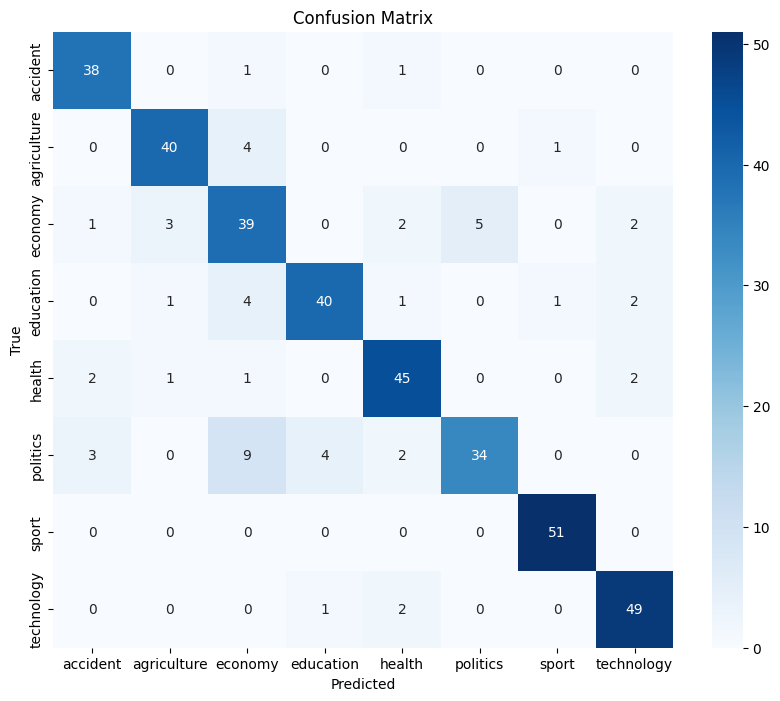

In [ ]:
# ============================
# Cell 14 — Evaluate on Test Set + Metrics Curves
# ============================

import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_full(model, loader):
    model.eval()
    preds, trues = [], []

    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in loader:
            if len(batch["input_ids"]) == 0:
                continue

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            if isinstance(logits, tuple):
                logits = logits[0]

            pred = torch.argmax(logits, dim=-1)
            preds.extend(pred.cpu().tolist())
            trues.extend(labels.cpu().tolist())

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        trues, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(trues, preds)

    return {
        "preds": preds,
        "labels": trues,
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# -----------------------------
# Evaluate on Test Set
# -----------------------------
test_results = evaluate_full(trained_model, test_loader)

print("\n==== Test Metrics ====")
print({
    "accuracy": test_results["acc"],
    "precision": test_results["precision"],
    "recall": test_results["recall"],
    "f1": test_results["f1"],
})

# Classification report
y_true = test_results["labels"]
y_pred = test_results["preds"]
target_names = [id2label[i] for i in sorted(id2label.keys())]

print("\n==== Classification Report ====\n")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# Plot training/validation curves
# -----------------------------
# Assuming you saved metrics lists during training:
# train_losses, val_losses, train_accs, val_accs
#plt.figure(figsize=(12, 5))

# 1️⃣ Losses
#plt.subplot(1, 2, 1)
#plt.plot(train_losses, label="Train Loss", marker='o')
#plt.plot(val_losses, label="Validation Loss", marker='o')
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.title("Training & Validation Loss")
#plt.legend()
#plt.grid(True)

# 2️⃣ Accuracies
#plt.subplot(1, 2, 2)
#plt.plot(train_accs, label="Train Acc", marker='o')
#plt.plot(val_accs, label="Validation Acc", marker='o')
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
#plt.title("Training & Validation Accuracy")
#plt.legend()
#plt.grid(True)

#plt.tight_layout()
#plt.show()


In [ ]:
# ================================
# Cell 15 — Save & Upload SentenceChuLoMBert to Hugging Face Hub (Colab-safe)
# ================================

import os
import torch
import json
from huggingface_hub import notebook_login, HfApi, create_repo, upload_folder

# -----------------------------
# 1️⃣ Login to Hugging Face
# -----------------------------
# This will prompt you to enter your API key interactively
notebook_login()

# -----------------------------
# 2️⃣ Set repo details
# -----------------------------
REPO_ID = "Abelex/chulo-mbert-amharic"  # change to your username/repo
MODEL_SAVE_DIR = "./saved_models"       # folder where model was trained
final_save = os.path.join(MODEL_SAVE_DIR, "final_chulo_mbert")
os.makedirs(final_save, exist_ok=True)

# -----------------------------
# 3️⃣ Prepare model for saving
# -----------------------------
# Handle DataParallel if used
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.to("cpu")

# Save state_dict
torch.save(model_to_save.state_dict(), os.path.join(final_save, "pytorch_model.bin"))

# Optional: save full model
torch.save(model_to_save, os.path.join(final_save, "full_model.pt"))

# Save tokenizer
tokenizer.save_pretrained(final_save)

# Save configuration
config = {
    "model_type": "chulo-mbert",
    "chunk_size": CHUNK_SIZE,
    "max_chunks": MAX_CHUNKS,
    "top_k_keys": TOP_K_KEYS,
    "key_alpha": KEY_ALPHA,
    "chunk_transformer_layers": CHUNK_TRANSFORMER_LAYERS,
    "chunk_dmodel": CHUNK_DMODEL,
    "num_labels": num_labels,
    "pretrained": PRETRAINED
}
with open(os.path.join(final_save, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

# -----------------------------
# 4️⃣ Push to Hugging Face Hub
# -----------------------------
api = HfApi()
create_repo(repo_id=REPO_ID, exist_ok=True)

upload_folder(
    folder_path=final_save,
    repo_id=REPO_ID,
)

print(f"✅ Model uploaded successfully: https://huggingface.co/{REPO_ID}")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...nal_chulo_mbert/vocab.txt: 100%|##########| 1.55MB / 1.55MB            

  ...o_mbert/pytorch_model.bin:   0%|          | 28.2kB /  719MB            

  ...chulo_mbert/full_model.pt:   0%|          |  557kB /  719MB            

✅ Model uploaded successfully: https://huggingface.co/Abelex/chulo-mbert-amharic


In [ ]:
# ===============================
# Cell 16 — Safe Sentence-Based ChuLo Inference (Updated)
# ===============================
import torch
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# ChuLo sentence-based chunking helper
# -----------------------------
def chunk_token_ids(token_ids, chunk_size, max_chunks, pad_token_id, cls_id=None, sep_id=None):
    """
    Split token IDs into fixed-size chunks with CLS/SEP tokens and padding.
    Safe truncation ensures we don't exceed max_chunks or chunk_size.
    """
    cls_id = cls_id or tokenizer.cls_token_id
    sep_id = sep_id or tokenizer.sep_token_id
    per_chunk = chunk_size - 2  # reserve space for CLS and SEP

    # Split tokens into sequential chunks
    chunks = [token_ids[i:i+per_chunk] for i in range(0, len(token_ids), per_chunk)]
    while len(chunks) < max_chunks:
        chunks.append([])  # pad empty chunks

    # Add CLS/SEP tokens + pad each chunk
    packed = []
    for ch in chunks[:max_chunks]:
        ch = ch[:per_chunk]
        ch = [cls_id] + ch + [sep_id]
        ch += [pad_token_id] * (chunk_size - len(ch))
        packed.append(ch)
    return packed

# -----------------------------
# Sentence-based prediction function
# -----------------------------
def predict_text(model, tokenizer, text, top_k=TOP_K_KEYS):
    """
    Predict label for a single document using sentence-based ChuLo-mBERT.
    Returns top prediction and top-k labels with probabilities.
    """
    model.to(DEVICE)
    model.eval()

    # Tokenize document without special tokens
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    token_ids = token_ids[:CHUNK_SIZE * MAX_CHUNKS]  # safe truncation

    # Sentence-based ChuLo chunking
    chunks = chunk_token_ids(
        token_ids,
        chunk_size=CHUNK_SIZE,
        max_chunks=MAX_CHUNKS,
        pad_token_id=tokenizer.pad_token_id
    )

    # Convert to tensor and move to device
    input_ids = torch.tensor([chunks], dtype=torch.long).to(DEVICE)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(DEVICE)

    # Forward pass
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(logits, tuple):
            logits = logits[0]  # in case model returns (loss, logits)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    # Top-1 prediction
    pred_id = int(np.argmax(probs))
    pred_label = id2label.get(pred_id, str(pred_id))

    # Top-k predictions
    topk_idx = probs.argsort()[-top_k:][::-1]
    topk_labels = [id2label[i] for i in topk_idx]
    topk_probs = probs[topk_idx]

    return pred_label, probs, topk_labels, topk_probs

# 🔥 Quick test on first training sample
text_example = train_df[TEXT_COLUMN].iloc[0]
label, probs, topk_labels, topk_probs = predict_text(trained_model, tokenizer, text_example)
print("Predicted Label:", label)
print("Top-k Labels:", topk_labels)
print("Top-k Probs:", topk_probs)


Predicted Label: accident
Top-k Labels: ['accident', 'health', 'education', 'economy']
Top-k Probs: [9.9768674e-01 1.1780004e-03 3.2662789e-04 2.5718298e-04]


In [ ]:
import gradio as gr
import numpy as np

def chulo_keyphrase_view(text):
    if not text.strip():
        return "Please enter text.", None, None

    # 1️⃣ ChuLo inference
    pred_label, probs, topk_labels, topk_probs = predict_text(trained_model, tokenizer, text)

    # 2️⃣ Prepare probability table
    rows = [(id2label[i], float(probs[i])) for i in range(len(probs))]
    rows = sorted(rows, key=lambda x: x[1], reverse=True)
    rows = rows[:5]

    # 3️⃣ Visualize keyphrases
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    chunks = chunk_token_ids(token_ids, CHUNK_SIZE, MAX_CHUNKS, tokenizer.pad_token_id)

    html_chunks = []
    for idx, ch in enumerate(chunks, 1):
        tokens = tokenizer.convert_ids_to_tokens(ch)
        # Fake key-token example: top `TOP_K_KEYS` tokens highlighted
        key_indices = list(range(min(TOP_K_KEYS, len(tokens))))
        chunk_html = " ".join(
            f"<span style='color:red;'>{t}</span>" if i in key_indices else t
            for i, t in enumerate(tokens)
        )
        html_chunks.append(f"<b>Chunk {idx}:</b> {chunk_html}")

    html_view = "<br>".join(html_chunks)

    return f"Predicted Label: {pred_label}", rows, html_view


demo = gr.Interface(
    fn=chulo_keyphrase_view,
    inputs=gr.Textbox(
        lines=5,
        label="Enter Amharic News Text",
        placeholder="እባክዎ የአማርኛ ዜና ጽሑፍ ያስገቡ..."
    ),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Dataframe(
            headers=["Label", "Probability"],
            label="Top Class Probabilities"
        ),
        gr.HTML(label="ChuLo Keyphrase Chunks (red = key tokens)")
    ],
    title="ChuLo – Amharic Keyphrase Chunk Classifier",
    description=(
        "This model uses ChuLo key-token attention to handle long Amharic texts, highlighting key tokens in red."
    ),
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://15db37b9d8e5a2ab3d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
